# Naive Bayes Model

In this notebook, I will try the Naive Bayes model to predict if the text was from Bioinformatics or Data Science subreddits. I will use GridSearch and different vectorizers CountVectorizer, TfidfVectorizer, and three different Tokenizers to see what works best with this data. 

---

In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB


# Import my custom functions for fitting and scoring models, tokenizing, and plotting residuals.
import functions_for_modeling

In [2]:
# Read the data
reddit = pd.read_csv('../data/reddit_cleaned_removed_words.csv')

In [3]:
# Split the data
X = reddit['title']
y = reddit['subreddit_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18,  stratify = y)

## Model on Title only

In [24]:
# Using Count Vectorizer
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [2000, 1000, 500],
    'cvec__min_df': [2, 1],
    'cvec__max_df': [0.9, 0.85],
    'cvec__stop_words': [None, 'english'],
    'nb__alpha': [1, 0.9, 0.8],
}

gs = GridSearchCV(pipe, 
                  param_grid = pipe_params,
                  n_jobs = -1,
                  cv = 5)

In [25]:
gs = functions_for_modeling.model_fit_scores(gs, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.8060395674612927
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': 'english', 'nb__alpha': 0.9}
Train accuracy: 0.9218950064020487
Test accuracy: 0.8157389635316699
F1 score: 0.6756756756756757


This model overfits, however, 81% accuracy is good for the first model, and F1 of 0.67 is OK

In [26]:
# Using TfidfVectorizer
pipe_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params_tf = {
    'tfidf__max_features': [2000, 3000, 4000, 5000],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [1, 0.9],
}

gs_tf = GridSearchCV(pipe_tf, 
                  param_grid = pipe_params_tf,
                  n_jobs = -1,
                  cv = 5)

In [27]:
gs_tf = functions_for_modeling.model_fit_scores(gs_tf, X_train, y_train, X_test, y_test)

Cross Validation Score: 0.7900303104775949
Best Parameters: {'nb__alpha': 0.9, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}
Train accuracy: 0.8982074263764405
Test accuracy: 0.8080614203454894
F1 score: 0.6062992125984251


This model performs a bit worse by both Accuracy and F1 score and is overfit as well

## Model on Title with Post body text

In [4]:
# Split the data
X_all = reddit['all_text']

X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, random_state = 18,  stratify = y)

In [29]:
# Using Count Vectorizer (pipe from first model)
pipe_params_all = {
    'cvec__max_features': [1000, 2000, 4000, 4500, 5000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.9, 0.85],
    'cvec__stop_words': [None, 'english'],
    'nb__alpha': [1, 0.9, 0.8],
}

gs_all = GridSearchCV(pipe, 
                  param_grid = pipe_params_all,
                  n_jobs = -1,
                  cv = 5)

In [30]:
gs_all = functions_for_modeling.model_fit_scores(gs_all, X_train_all, y_train, X_test_all, y_test)

Cross Validation Score: 0.8777463750307201
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__stop_words': 'english', 'nb__alpha': 0.8}
Train accuracy: 0.9539052496798975
Test accuracy: 0.8829174664107485
F1 score: 0.8087774294670846


This model is much better than the one fitted only with Title. The F1 score is higher and Test and Train accuracy is much closer together (less overfitting)

## Model with Tokenization and Lemmatizing or Stemming

In [5]:
# Fit the model using Text Blob Tokenizer and Stemmer
textblob = functions_for_modeling.model_tokenazer(MultinomialNB(alpha=0.8), 'nb', functions_for_modeling.textblob_tokenizer, 2, 4000, 0.9, X_train_all, y_train, X_test_all, y_test)

Cross Validation Score: 0.8790345703285001
Train accuracy: 0.9475032010243278
Test accuracy: 0.8886756238003839
F1 score: 0.8152866242038217


In [32]:
# Fit the model using NLTK Tokenizer and Lemmetizer
t_lem = functions_for_modeling.model_tokenazer(MultinomialNB(alpha=0.8), 'nb', functions_for_modeling.tokenizer_lemmatizer, 2, 4000, 0.9, X_train_all, y_train, X_test_all, y_test)

Cross Validation Score: 0.8777607110674204
Train accuracy: 0.9468629961587708
Test accuracy: 0.8790786948176583
F1 score: 0.801261829652997


In [33]:
# Fit the model using NLTK Tokenizer and Stemmer
t_stem = functions_for_modeling.model_tokenazer(MultinomialNB(alpha=0.8), 'nb', functions_for_modeling.tokenizer_stemmer, 2, 4000, 0.9, X_train_all, y_train, X_test_all, y_test)

Cross Validation Score: 0.8777545670516916
Train accuracy: 0.9468629961587708
Test accuracy: 0.8809980806142035
F1 score: 0.8037974683544303


I have fitted all my tokenized models with parameters from the best model so far. Text Blob Tokenizer with Stemmer improved the scores, especially F1, and reduced overfitting.

In [8]:
# Random search parameters of my best tokenized model to improve scores.
pipe_tn = Pipeline([
    ('cvec', CountVectorizer(tokenizer=functions_for_modeling.textblob_tokenizer)),
    ('nb', MultinomialNB())
])

pipe_params_tn = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [0.9, 0.85],
    'nb__alpha': [0.9, 0.8],
}

nb_tn = RandomizedSearchCV(pipe_tn, 
                       param_distributions = pipe_params_tn,
                       n_jobs = -1,
                       cv = 5, 
                       random_state=18,
                       n_iter=12)


nb_tn = functions_for_modeling.model_fit_scores(nb_tn, X_train_all, y_train, X_test_all, y_test)

Cross Validation Score: 0.8790325223232571
Best Parameters: {'nb__alpha': 0.9, 'cvec__min_df': 2, 'cvec__max_features': 4000, 'cvec__max_df': 0.85}
Train accuracy: 0.9455825864276568
Test accuracy: 0.8848368522072937
F1 score: 0.8076923076923077


The model has lower scores, that the one fitted on previous hyperparameters. I will use them for Stacking with Tokenizers. Randomized search with Tokenized models takes a long time to run, I had to use fewer iterations and hyperparameters for tuning.

---

## Plot the Residuals of the best model

My best model for this notebook is Naive Bayes with Count Vectorizer and Text Blob Tokenizing with Stemming fitted on both Title and Body Texts.

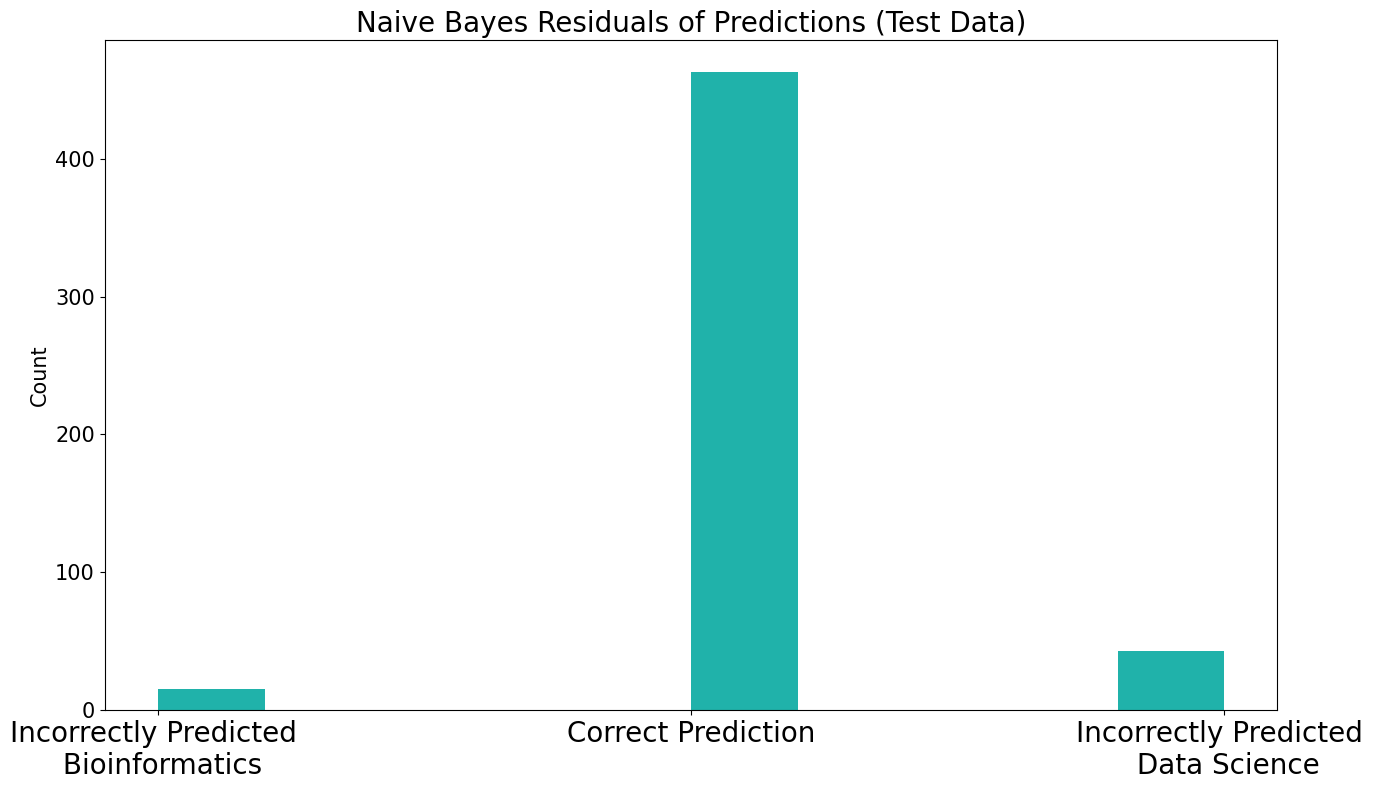

In [9]:
# Plot the resuduals of the mest model
functions_for_modeling.plot_residuals(textblob, X_test_all, y_test, 'Naive Bayes', 'nb_residuals')

The Naive Bayes model has more errors in predicting Bioinformatics. It is understandable as the amount of data for Data Science is higher than for Bioinformatics.

---

I created the Naive Bayes models in this notebook with Count Vectorizer, TFidf Vectorizer, and Tokenizers.
The model with the Count Vectorizer performed better.
I have tried three different Tokenizers and found that the Text Blob tokenizer with Stemming has the highest scores from all my Naive Bayes models.
In the next Notebook, I will explore XGBoost and Gradient Boost models.